In [1]:
from numpy import *; from numpy.core.records import fromarrays;from scipy.constants import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time

def e_ratio(T):
    '''Gives m_e/E, where E=m+T is input in terms of keV'''
    e_mass=m_e*c**2./(kilo*eV)
    return 1./(1.+T/e_mass)

#### Reading in detector response pars

In [2]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)

#### Initializing simulation data

In [3]:
nbins,rang=1000,[0,800]
full_load=False

path='/home/noah/Desktop/large_analysis/zeck_simulation/BSG/'
b0=np.load(path+'b0.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
b1=np.load(path+'b1.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
alpha0,alpha1=np.sum(b0.Ne),np.sum(b1.Ne)


path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
if full_load==True:
    b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')               # Reading in 45Ca b=1 b=0 PENELOPE spectra
    b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)                   # Restructuring the sim data
    b0,b1=b0.view(recarray),b1.view(recarray)                             # Making the spectra record arrays (easier)
    Fullb0,Fullb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)  #Perfect summed simulated spectra
    Fullb0,Fullb1=Fullb0.view(recarray),Fullb1.view(recarray)
    np.save(path+'Fullb0',Fullb0)
    np.save(path+'Fullb1',Fullb1)
else:
    Fullb0,Fullb1=np.load(path+'Fullb0.npy').view(np.recarray),np.load(path+'Fullb1.npy').view(np.recarray)
Fullb0_hist=histogram(Fullb0.energy,bins=nbins,range=rang)[0]
Fullb1_hist=histogram(Fullb1.energy,bins=nbins,range=rang)[0]
Norm_b0 = 1./np.sum(Fullb0_hist)        # This is used later when taking difference of b=1 and b=0 spectra
Norm_b1 = 1./np.sum(Fullb1_hist)        # This is used later when taking difference of b=1 and b=0 spectra

#### Making simulated single pixel spectra & Smearing
Note: the smearing is done here. E-->E+deltaE, where deltaE=np.random.normal(loc=0,scale=sigma)

In [4]:
thresh=200                     # in ADC
coinc_window=400e-9
bdchs=[17,41]                            #In this routine, we're removing any events that hit 77W/E
# bdchs=[11]                            #This includes 52,64,65W and 64E
if full_load==True:
    truth0,truth1=np.zeros(len(b0),dtype=bool),np.zeros(len(b1),dtype=bool)
    for bdch in bdchs:                     #Taking sim events ONLY for bdchs
        bd,ch=int(bdch/8),int(bdch%8)
        truth0+=np.logical_not((b0.board==bd)*(b0.channel==ch))
        truth1+=np.logical_not((b1.board==bd)*(b1.channel==ch))
    sb0,sb1=b0[truth0],b1[truth1]
    sb0,sb1=sb0.view(np.recarray),sb1.view(np.recarray)


    bdchs=[6,11,12,35,36]
    for bdch in bdchs:
        bd,ch=int(bdch/8),int(bdch%8)
        sigma=detector_response[bdch]                 # Detector response for bd,ch
        trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
        sb0.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))
        trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb0= with bd ch
        sb1.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))

    sb0=sb0[sb0.energy>thresh/6.2]                          #Applying threshold cut to sim
    sb1=sb1[sb1.energy>thresh/6.2]                    #Applying threshold cut to sim

    sb0=pd.sim_sing_pix_coinc(sb0,coinc_window) #Summing events within a coinc_window timewindow
    sb0=sb0[pd.sim_single_event(sb0)]           # Making single pixel sim spectra
    sb1=pd.sim_sing_pix_coinc(sb1,coinc_window) #Summing events within a coinc_window timewindow
    sb1=sb1[pd.sim_single_event(sb1)]           # Making single pixel sim spectra
else:
    sb0,sb1=np.load(path+'sb0.npy').view(np.recarray),np.load(path+'sb1.npy').view(np.recarray)

#### Making simulated single pixel histograms

In [7]:
b0_hist,bins=histogram([],bins=nbins,range=rang)   #b0 single pixel histogram
b1_hist,bins=histogram([],bins=nbins,range=rang)   #b1 single pixel histogram
b0_hist,b1_hist=b0_hist.astype(float),b1_hist.astype(float)
bins=pd.cbins(bins)

# bdchs_of_interest=bdchs

bdchs_of_interest=[35]
for bdch in bdchs_of_interest:             # Looping over bdchs to smear sim pixel-by-pixel
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
    b0_hist+=histogram(sb0.energy[trutharray],bins=nbins,range=rang)[0]
    
    trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb1= with bd ch
    b1_hist+=histogram(sb1.energy[trutharray],bins=nbins,range=rang)[0]
print(np.sum(b0_hist),np.sum(b1_hist))
b0_hist*=Norm_b0
b1_hist*=Norm_b1                            # Normalizing the total number of counts in b1 to that of b1
# b0_hist*=1./np.sum(b0_hist)
# b1_hist*=1./np.sum(b1_hist)                            # Normalizing the total number of counts in b1 to that of b1

3389087.0 3266423.0


## Calibrating b=1 events to ADC

In [8]:
d=sb1.copy()
for item in pd.calibration:
    bd,ch=item.board,item.channel
    t=(d.board==bd)*(d.channel==ch)
    d.energy[t]=d.energy[t]*item.slope+item.offset

trutharray=np.zeros(len(d),dtype=bool)
for bdch in bdchs_of_interest:
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(d.board==bd)*(d.channel==ch)
d=d[trutharray]


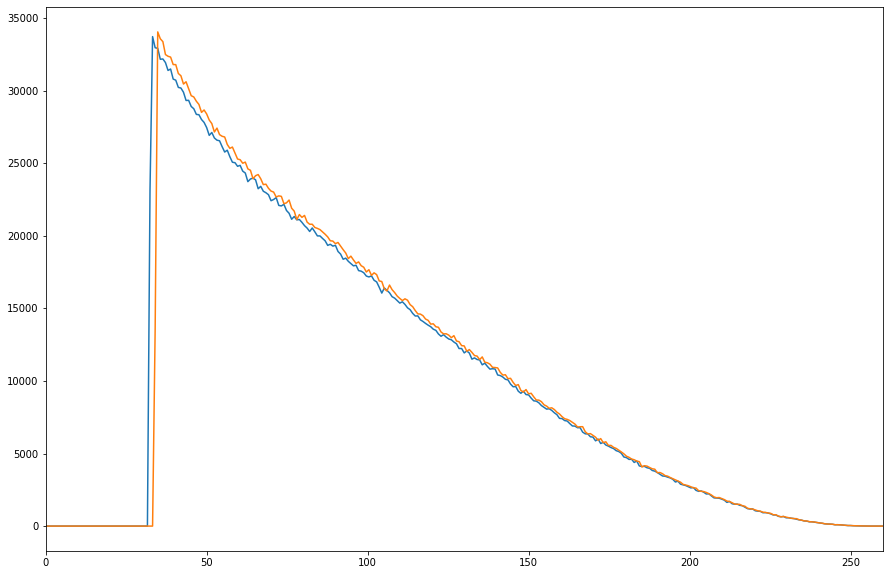

In [76]:
bd,ch=divmod(bdchs_of_interest[0],8)
t=(pd.calibration.board==bd)*(pd.calibration.channel==ch)
cal=pd.calibration[t]
offset=cal.offset
slope=cal.slope
slope_err=cal.slope_err
off_err=cal.off_err

rand_off=np.random.normal(scale=off_err)
rand_slope=np.random.normal(scale=slope_err)



fig,ax=subplots(figsize=(15,10))
d_hist=histogram((d.energy-offset)/(slope)\
                 ,bins=nbins,range=rang)[0]
ax.plot(bins,d_hist)
d_hist=histogram((d.energy-offset+rand_off)/(slope+rand_slope)\
                 ,bins=nbins,range=rang)[0]
ax.plot(bins,d_hist)
ax.set_xlim(0,260)
show()

In [9]:
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
steps=arange(100,end-10,2)
true_bs=[]
true_b_err=[]

beg_bad,end_bad=100,100


minb=np.zeros(len(steps))
maxb=np.zeros(len(steps))
b=np.zeros(shape=(len(steps),0))
temps=np.zeros(len(steps))
bd,ch=divmod(bdchs_of_interest[0],8)
t=(pd.calibration.board==bd)*(pd.calibration.channel==ch)
cal=pd.calibration[t]
offset=cal.offset
slope=cal.slope
slope_err=cal.slope_err
off_err=cal.off_err

cal=load('/home/noah/Desktop/large_analysis/ca_analysis/simulation_comparison/64E_calibs.npy').view(np.recarray)
done=False
for j in range(1000):
    if j%100==0:
        print('\r'+50*' ',end='')
        print('\r'+'{:0d} percent complete'.format(int(j/1000*100)),end='')
    slope,offset=cal[j].slope,cal[j].offset
    d_hist=histogram((d.energy-offset)/(slope)\
                     ,bins=nbins,range=rang)[0]
    
    for i,beg in enumerate(steps):
        if beg > end_bad:
            trutharray = ((bins>beg)*(bins<end))  # Trutharray for fit window
        else:
            trutharray = ((bins>beg)*(bins<beg_bad))+((bins>end_bad)*(bins<end))  # Trutharray for fit window

        weights=np.sqrt(d_hist[trutharray])
        X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit
#         X=(trutharray,b0_hist,b1_hist)   # Independent values for curve_fit

        pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                          p0=[d_hist[trutharray][0],0],sigma=weights,\
                           absolute_sigma=False,maxfev=1000000,ftol=1e-8)
    #                       epsfcn=1e-9)

        vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors
#         if pars[1]>1e2:
#             print(pars)
#             done=True
#             break
        chisq=np.sum((d_hist[trutharray]-pd.fierz_fit(X,*pars))**2./d_hist[trutharray])/(np.sum(trutharray)-len(pars))
        out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
        b_vals=vstack((b_vals,out))
        temps[i]=pars[1]
    b=np.hstack((b,temps[:,None]))
#     if done:
#         break
# fig,ax=subplots(figsize=(15,10))
# ax.plot(bins[trutharray],d_hist[trutharray],ds='steps',label='data\n slope: {:0.1f} offset: {:0.1e}'.format(slope,offset))
# X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)
# ax.plot(bins[trutharray],pd.fierz_fit(X,*pars),ds='steps',label='b={:1.2e} norm={:1.2e}'.format(pars[1],pars[0]))
# ax.set_xlabel('keV',fontsize=fs)
# ax.set_xlim(0,260)
# ax.legend(fontsize=fs)
# show()
names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats
print('\nDone')

90 percent complete                               
Done


In [119]:
count=0
for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        if b[i,j]>1e2:
            b[i,j]=np.nan

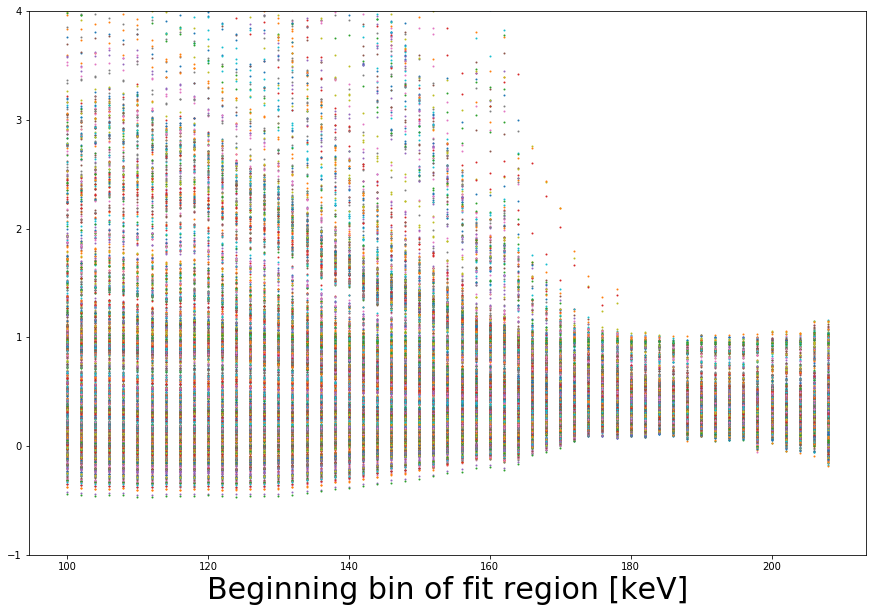

In [10]:
fs=30
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
for i in range(b.shape[1]):
    ax.plot(steps,b[:,i],'o',ms=1)
# ax.set_xlim(130,140)
ax.set_ylim(-1,4)
ax.set_xlabel('Beginning bin of fit region [keV]',fontsize=fs)
show()

(55,) 3075.1037156877073


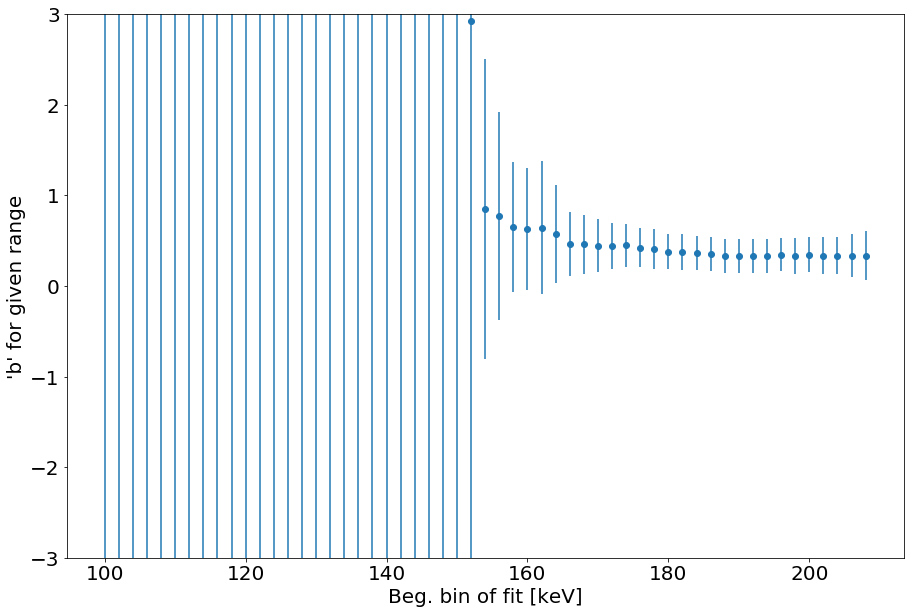

In [11]:
fs=20
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
mean=np.nanmean(b,axis=1)
sigma=np.nanstd(b,axis=1)
print(steps.shape,mean[0])
ax.errorbar(steps,mean,sigma,fmt='o')
ax.set_ylim(-3,3)
ax.set_ylabel('\'b\' for given range',fontsize=fs)
ax.set_xlabel('Beg. bin of fit [keV]',fontsize=fs)
ax.tick_params(labelsize=fs)
# ax.set_xlim(100,220)
# print(np.max(b,axis=1),b.shape)
# print(b[0,:],np.sum(b[0,:]>10))
show()

15.383495139050325 247.07348200982582


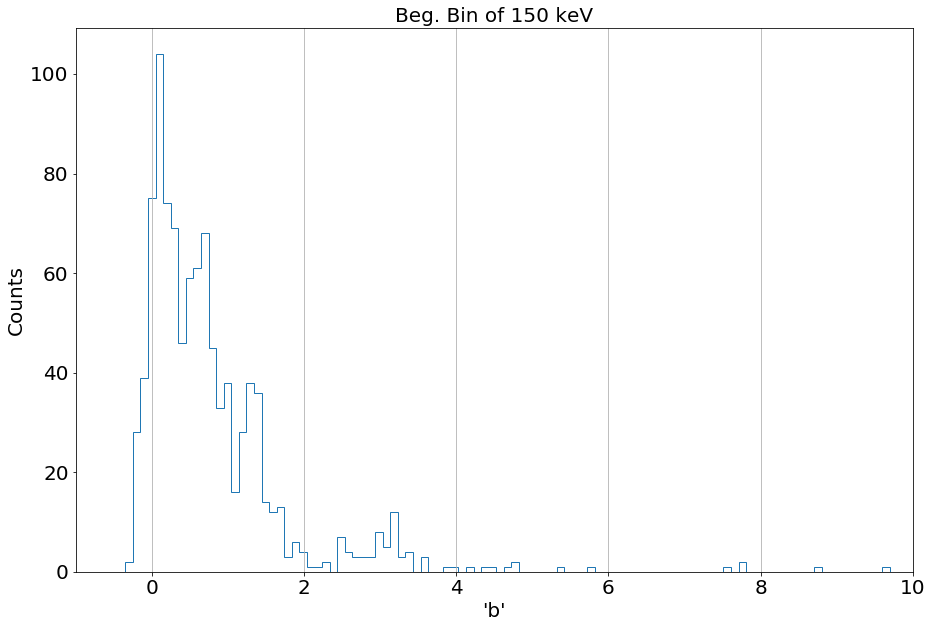

In [19]:
fs=20
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
t=150
t=np.nonzero(steps==t)[0][0]
print(np.mean(b[t,:]),np.std(b[t,:]))
h,b,ax.hist(b[t,:],bins=201,range=[-10,10],histtype='step')
# ax.set_ylim(0,1)
ax.set_ylabel('Counts',fontsize=fs)
ax.set_xlabel('\'b\'',fontsize=fs)
ax.set_title('Beg. Bin of {:0d} keV'.format(steps[t]),fontsize=fs)
ax.tick_params(labelsize=fs)
ax.grid(axis='x')
ax.set_xlim(-1,10)
show()

path='/home/noah/Desktop/large_analysis/zeck_simulation/BSG/'
w0=np.load(path+'b0.npy').view(recarray);w0.Ne=w0.Ne/np.sum(w0.Ne)
w1=np.load(path+'b1.npy').view(recarray);w1.Ne=w1.Ne/np.sum(w1.Ne)
energy=w0.energy
w_ratio=lambda E: w1.Ne[E]/w0.Ne[E]
fierz=lambda b,E1,E2: b*(w_ratio(E1)-w_ratio(E2))/\
     ((1+b*(w_ratio(E2)-1))*e_ratio(energy[E1])-(1+b*(w_ratio(E1)-1))*e_ratio(energy[E2]))
kev102=np.where(bins==102)[0][0]
kev182=np.where(bins==182)[0][0]

fs=30
fig,ax=subplots(nrows=2,ncols=2,figsize=(30,20))

for i in range(len(b_vals)):
    vals=b_vals[i]
    X=(np.ones(len(bins),dtype=bool),b0_hist,b1_hist)
#     if i%3==0:
    if i<10:
        ax[0,0].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.2f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))
text='Pixels included:\n'
for bdch in bdchs:
    bd=int(bdch/8);ch=int(bdch%8)
    text+=pd.pixel(bd,ch)+'\n'
trutharray=b_vals.beg<=100
ax[0,0].plot(bins,d_hist,ds='steps',label='Data',lw=5)        
ax[0,0].legend(fontsize=fs-10)
ax[0,0].set_xlim(0,300)
ax[0,0].tick_params(labelsize=fs)
ax[0,0].set_title('Resulting Spectra',fontsize=fs)
ax[0,0].set_xlabel('Energy [keV]',fontsize=fs)
# ax[0,0].set_yscale('log')
ax[0,1].errorbar(b_vals.beg,b_vals.b,b_vals.b_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.b[trutharray].mean())+': {:0.2f}'.format(b_vals.b[trutharray].std()))
ax[0,1].legend(fontsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[0,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[0,1].grid()
ax[0,1].set_ylabel('b',fontsize=fs)
ax[0,1].set_title('Fitted b values',fontsize=fs)
ax[0,1].set_ylim(-1,1)
ax[1,0].errorbar(b_vals.beg,b_vals.N,b_vals.N_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.N[trutharray].mean())+': {:0.2f}'.format(b_vals.N[trutharray].std()))
ax[1,0].legend(fontsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[1,0].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[1,0].set_ylabel('Normalization fit parameter',fontsize=fs)
ax[1,0].set_title('Normalization Fit Parameter',fontsize=fs)
ax[1,0].grid()
ax[1,1].plot(b_vals.beg,b_vals.chisq,marker='o',ls='None',\
             label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.chisq[trutharray].mean())+': {:0.2f}'.format(b_vals.chisq[trutharray].std()))
ax[1,1].legend(fontsize=fs)
ax[1,1].tick_params(labelsize=fs)
ax[1,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[1,1].set_ylabel(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].set_title(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].grid()
for i in range(1,4):
    row=int(i/2);col=int(i%2)
    ax[row,col].set_xlim(55,105)
fig.text(0.525,0.5,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
text='Threshold: '+str(thresh)+' keV'
fig.text(0.525,0.025,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
# ax[1].set_ylim(-2,2)
tight_layout()
savefig('single-pixel-T'+str(thresh))
show()